# Scratch space

In [2]:
import xarray as xr
ds = xr.open_dataset('../test_results_todo.nc')
ds

<xarray.Dataset>
Dimensions:                (time: 48, walker: 150, sample: 1000)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23...
Dimensions without coordinates: walker, sample
Data variables:
    map_radon              (time) float64 ...
    model_time             (time) timedelta64[ns] ...
    r_screen_scale         (walker, sample) float64 ...
    exflow_scale           (walker, sample) float64 ...
    radon                  (time, walker, sample) float64 ...
    counts                 (time) float64 ...
    background_count_rate  (time) float64 ...
    sensitivity            (time) float64 ...
    q_internal             (time) float64 ...
    q_external             (time) float64 ...
    airt                   (time) float64 ...

In [3]:
ds.time

<xarray.DataArray 'time' (time: 48)>
array(['2000-01-01T00:00:00.000000000', '2000-01-01T00:30:00.000000000',
       '2000-01-01T01:00:00.000000000', '2000-01-01T01:30:00.000000000',
       '2000-01-01T02:00:00.000000000', '2000-01-01T02:30:00.000000000',
       '2000-01-01T03:00:00.000000000', '2000-01-01T03:30:00.000000000',
       '2000-01-01T04:00:00.000000000', '2000-01-01T04:30:00.000000000',
       '2000-01-01T05:00:00.000000000', '2000-01-01T05:30:00.000000000',
       '2000-01-01T06:00:00.000000000', '2000-01-01T06:30:00.000000000',
       '2000-01-01T07:00:00.000000000', '2000-01-01T07:30:00.000000000',
       '2000-01-01T08:00:00.000000000', '2000-01-01T08:30:00.000000000',
       '2000-01-01T09:00:00.000000000', '2000-01-01T09:30:00.000000000',
       '2000-01-01T10:00:00.000000000', '2000-01-01T10:30:00.000000000',
       '2000-01-01T11:00:00.000000000', '2000-01-01T11:30:00.000000000',
       '2000-01-01T12:00:00.000000000', '2000-01-01T12:30:00.000000000',
       '2000-01-01T13:00:00.000000000', '2000-01-01T13:30:00.000000000',
       '2000-01-01T14:00:00.000000000', '2000-01-01T14:30:00.000000000',
       '2000-01-01T15:00:00.000000000', '2000-01-01T15:30:00.000000000',
       '2000-01-01T16:00:00.000000000', '2000-01-01T16:30:00.000000000',
       '2000-01-01T17:00:00.000000000', '2000-01-01T17:30:00.000000000',
       '2000-01-01T18:00:00.000000000', '2000-01-01T18:30:00.000000000',
       '2000-01-01T19:00:00.000000000', '2000-01-01T19:30:00.000000000',
       '2000-01-01T20:00:00.000000000', '2000-01-01T20:30:00.000000000',
       '2000-01-01T21:00:00.000000000', '2000-01-01T21:30:00.000000000',
       '2000-01-01T22:00:00.000000000', '2000-01-01T22:30:00.000000000',
       '2000-01-01T23:00:00.000000000', '2000-01-01T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:30:00

In [2]:
import numpy as np

## A new transform for radon 

In [3]:
radon = np.arange(8, dtype=float)
num_levels = int(np.log2(len(radon)))

# must be an exact power of 2
assert 2**num_levels == len(radon)

# calculate mean over each level
row = radon
averages = [radon]
params = []
params_flat = []
for ii in range(num_levels):
    # reshape - elements are paired, first column is first
    # element in each pair and second column is the second
    # in each pair
    row2d = row.reshape((-1,2))
    # average of consecutive elements
    row = row2d.mean(axis=1)
    averages.append(row)
    # first element / average
    parameters = row2d[:,0] / row
    params.append(parameters)
    params_flat.extend(parameters)
    

params.append(row)
params_flat.extend(row)
params_flat = np.array(params_flat)


In [4]:
# reconstruction
rp = params_flat.copy() #[::-1]
a = np.array([rp[-1]])
rp = rp[:-1]
n = 1
for ii in range(1, num_levels+1):
    # parameters for this level of the reconstruction
    p = rp[-n:]
    # remaining parameters
    rp = rp[:-n]
    # reconstruct this level
    b = np.zeros(n*2, dtype=float)
    b[::2] = a * p
    b[1::2] = a * (2.0 - p)
    a = b
    n *= 2

a
    

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [14]:
def transform(radon):
    num_levels = int(np.log2(len(radon)))

    # must be an exact power of 2
    assert 2**num_levels == len(radon)

    # calculate mean over each level
    row = radon
    params_flat = []
    for _ in range(num_levels):
        # reshape - elements are paired, first column is first
        # element in each pair and second column is the second
        # in each pair
        row2d = row.reshape((-1,2))
        # average of consecutive elements
        row = row2d.mean(axis=1)
        # first element / average
        parameters = row2d[:,0] / row
        params.append(parameters)
        params_flat.extend(parameters)
        

    params_flat.extend(row)
    params_flat = np.array(params_flat)
    return params_flat #np.log(params_flat)


def inverse_transform(params):
    num_levels = int(np.log2(len(params)))

    # must be an exact power of 2
    assert 2**num_levels == len(params)


    # reconstruction
    #rp = np.exp(params)
    rp = params.copy()
    a = np.array([rp[-1]])
    rp = rp[:-1]
    n = 1

    for _ in range(1, num_levels+1):
        # parameters for this level of the reconstruction
        p = rp[-n:]
        # remaining parameters
        rp = rp[:-n]
        # reconstruct this level
        b = np.zeros(n*2, dtype=float)
        b[::2] = a * p
        b[1::2] = a * (2.0 - p)
        a = b
        n *= 2

    radon = a

    return radon



In [16]:
np.arange(16, dtype=float)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

In [17]:
transform(np.arange(16, dtype=float))

array([0.        , 0.8       , 0.88888889, 0.92307692, 0.94117647,
       0.95238095, 0.96      , 0.96551724, 0.33333333, 0.81818182,
       0.89473684, 0.92592593, 0.42857143, 0.82608696, 0.46666667,
       7.5       ])

In [7]:
inverse_transform(transform(np.arange(128, dtype=float)))

<ipython-input-5-840c81749253>:25: RuntimeWarning: divide by zero encountered in log
  return np.log(params_flat)


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127.])

In [10]:
transform(np.arange(16, dtype=float))

<ipython-input-5-840c81749253>:25: RuntimeWarning: divide by zero encountered in log
  return np.log(params_flat)


array([       -inf, -0.22314355, -0.11778304, -0.08004271, -0.06062462,
       -0.04879016, -0.04082199, -0.03509132, -1.09861229, -0.2006707 ,
       -0.11122564, -0.07696104, -0.84729786, -0.19105524, -0.76214005,
        2.01490302])

<ipython-input-5-840c81749253>:25: RuntimeWarning: divide by zero encountered in log
  return np.log(params_flat)


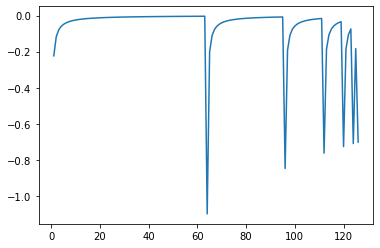

In [9]:
import matplotlib.pyplot as plt
plt.plot(transform(np.arange(128, dtype=float))[:-1])

In [12]:
3/2.

1.5

In [13]:
2/(2+3)

0.4